In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import GPyOpt
import random
from IPython.display import clear_output
import time

In [2]:
# set seeds 
seed=42
random.seed(seed)  # Python
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch
torch.cuda.manual_seed_all(seed)  # PyTorch CUDA

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 datasets
data_dir = '../CIFAR10_data'
trainset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)
testset = datasets.CIFAR10(data_dir, download=True, train=False, transform=transform)

# Assuming you start with a small labeled dataset and the rest is unlabeled
initial_train_size = 1000
unlabeled_size = len(trainset) - initial_train_size

trainset_labeled_indices = list(range(initial_train_size))
trainset_unlabeled_indices = list(range(initial_train_size, len(trainset)))

labeled_set = torch.utils.data.Subset(trainset, trainset_labeled_indices)
unlabeled_set = torch.utils.data.Subset(trainset, trainset_unlabeled_indices)

trainloader = torch.utils.data.DataLoader(labeled_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


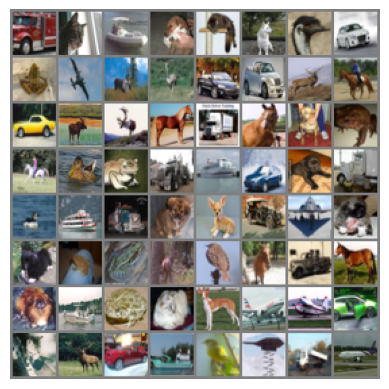

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# example showcase
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))

# CNN architecture

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training & evaluation

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [8]:
# Function to evaluate the model
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Baseline

In [9]:
def random_sampling_training(model, trainset, trainset_labeled_indices, trainset_unlabeled_indices, testloader, criterion, optimizer, num_epochs, num_iterations, num_samples):
    train_indices = list(trainset_labeled_indices)
    unlabeled_indices = list(trainset_unlabeled_indices)
    accuracies = []

    # Using tqdm for progress bar
    for iteration in tqdm(range(num_iterations), desc='Random Sampling Iteration'):
        # Randomly select new samples to add to the training set
        new_samples = np.random.choice(unlabeled_indices, num_samples, replace=False)
        train_indices.extend(new_samples)
        unlabeled_indices = [idx for idx in unlabeled_indices if idx not in new_samples]

        # Update the training dataset and loader
        train_dataset = Subset(trainset, train_indices)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Train and evaluate
        train_model(model, train_loader, criterion, optimizer, num_epochs)
        accuracy = evaluate_model(model, testloader)
        accuracies.append(accuracy)

    return accuracies

# Active learning

In [10]:
def active_learning_sampling(model, trainset, trainset_labeled_indices, testloader, criterion, optimizer, num_epochs, num_iterations, num_samples, sampling_method):
    train_indices = set(trainset_labeled_indices)
    unlabeled_indices = set(range(len(trainset))) - train_indices
    accuracies = []

    for iteration in tqdm(range(num_iterations), desc=f'{sampling_method} Sampling Iteration'):
        trainloader = DataLoader(Subset(trainset, list(train_indices)), batch_size=64, shuffle=True)
        
        # Train and evaluate
        train_model(model, trainloader, criterion, optimizer, num_epochs)
        accuracy = evaluate_model(model, testloader)
        accuracies.append(accuracy)

        if sampling_method != 'random':
            model.eval()
            uncertainties = torch.tensor([]).to(device)
            unlabeled_loader = DataLoader(Subset(trainset, list(unlabeled_indices)), batch_size=64)

            with torch.no_grad():
                for images, _ in unlabeled_loader:
                    images = images.to(device)
                    outputs = model(images)
                    probabilities = F.softmax(outputs, dim=1)
                    
                    if sampling_method == 'Entropy':
                        uncertainty = -torch.sum(probabilities * torch.log(probabilities + 1e-5), dim=1)
                    elif sampling_method == 'Least_confidence':
                        uncertainty = 1 - torch.max(probabilities, dim=1).values

                    uncertainties = torch.cat((uncertainties, uncertainty.cpu()))

            if sampling_method == 'Entropy':
                sampled_indices = uncertainties.topk(num_samples).indices
            elif sampling_method == 'Least_confidence':
                sampled_indices = uncertainties.topk(num_samples, largest=False).indices

            sampled_indices = [list(unlabeled_indices)[i] for i in sampled_indices.cpu().numpy()]
        else:
            sampled_indices = np.random.choice(list(unlabeled_indices), num_samples, replace=False)

        train_indices.update(sampled_indices)
        unlabeled_indices.difference_update(sampled_indices)

    return accuracies

# Definitions

In [11]:
baseline_model = CNN()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

entropy_model = CNN()
entropy_optimizer = optim.Adam(entropy_model.parameters(), lr=0.001)

least_confidence_model = CNN()
least_confidence_optimizer = optim.Adam(least_confidence_model.parameters(), lr=0.001)

baseline_model = baseline_model.to(device)
entropy_model = entropy_model.to(device)
least_confidence_model = least_confidence_model.to(device)

# Set common training parameters
num_epochs = 8
num_iterations = 2
num_samples = 500

# Common loss function and dataset
criterion = nn.CrossEntropyLoss()

# Comparison of random sampling vs entropy uncertainty sampling vs least confidence uncertainty sampling

In [12]:
# Training with random sampling
random_accuracies = random_sampling_training(
    baseline_model,
    trainset,
    trainset_labeled_indices,
    trainset_unlabeled_indices,
    testloader,
    criterion,
    baseline_optimizer,
    num_epochs,
    num_iterations,
    num_samples
)

# Training with entropy based sampling
entropy_accuracies = active_learning_sampling(
    entropy_model,
    trainset,
    trainset_labeled_indices,
    testloader,
    criterion,
    entropy_optimizer,
    num_epochs,
    num_iterations,
    num_samples,
    'Entropy'
)

# Training with least confidence based sampling
least_confidence_accuracies = active_learning_sampling(
    least_confidence_model,
    trainset,
    trainset_labeled_indices,
    testloader,
    criterion,
    least_confidence_optimizer,
    num_epochs,
    num_iterations,
    num_samples,
    'Least_confidence'
)

Random Sampling Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: train_model() takes 5 positional arguments but 6 were given

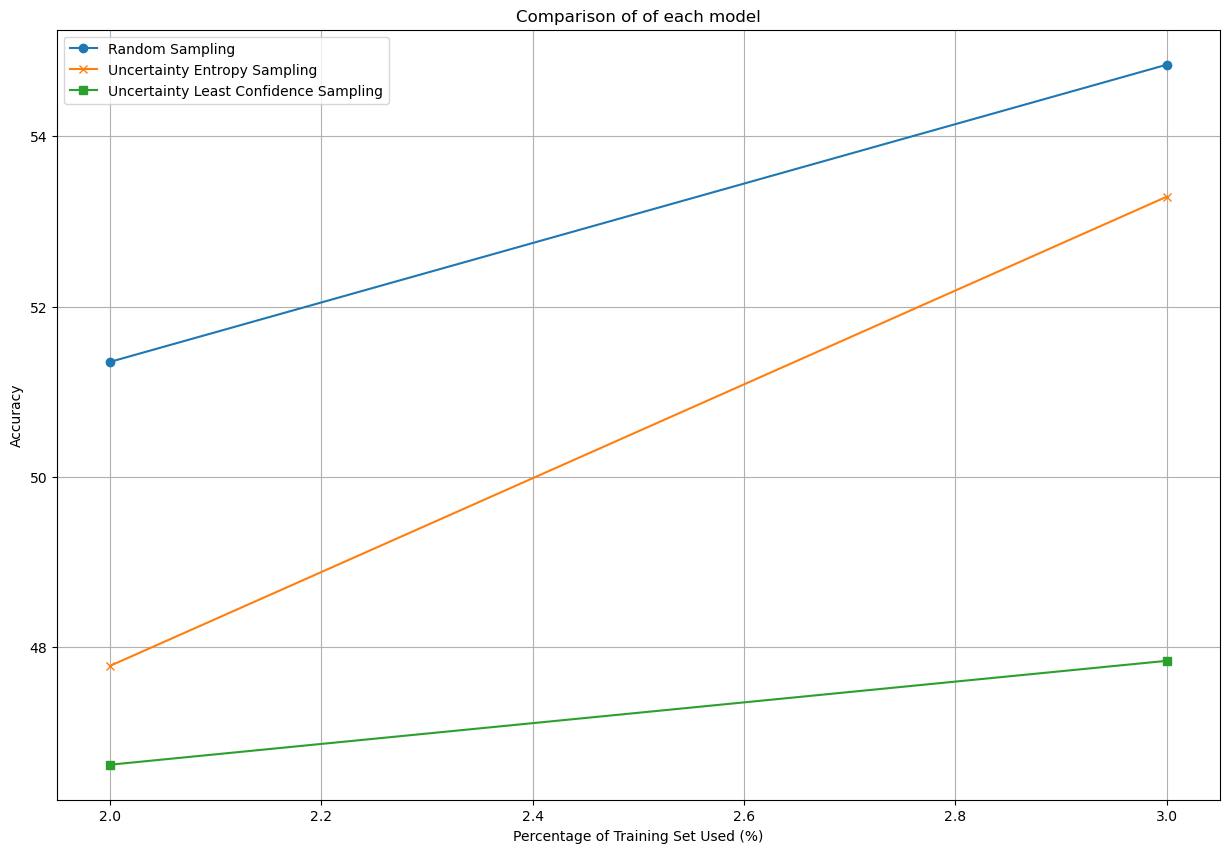

In [ ]:
# Create a list representing the percentage of the training set used at each iteration
percentage_of_training_used = [(i * num_samples + len(trainset_labeled_indices)) / len(trainset) * 100 for i in range(num_iterations)]

plt.figure(figsize=(15, 10))  # Increase the size of the figure
plt.plot(percentage_of_training_used, random_accuracies, 'o-', label='Random Sampling')  # Add circle markers
plt.plot(percentage_of_training_used, entropy_accuracies, 'x-', label='Uncertainty Entropy Sampling')  # Add x markers
plt.plot(percentage_of_training_used, least_confidence_accuracies, 's-', label='Uncertainty Least Confidence Sampling')  # Add square markers
plt.xlabel('Percentage of Training Set Used (%)')
plt.ylabel('Accuracy')
plt.title('Comparison of of each model')
plt.legend()
plt.grid(True)
plt.show()

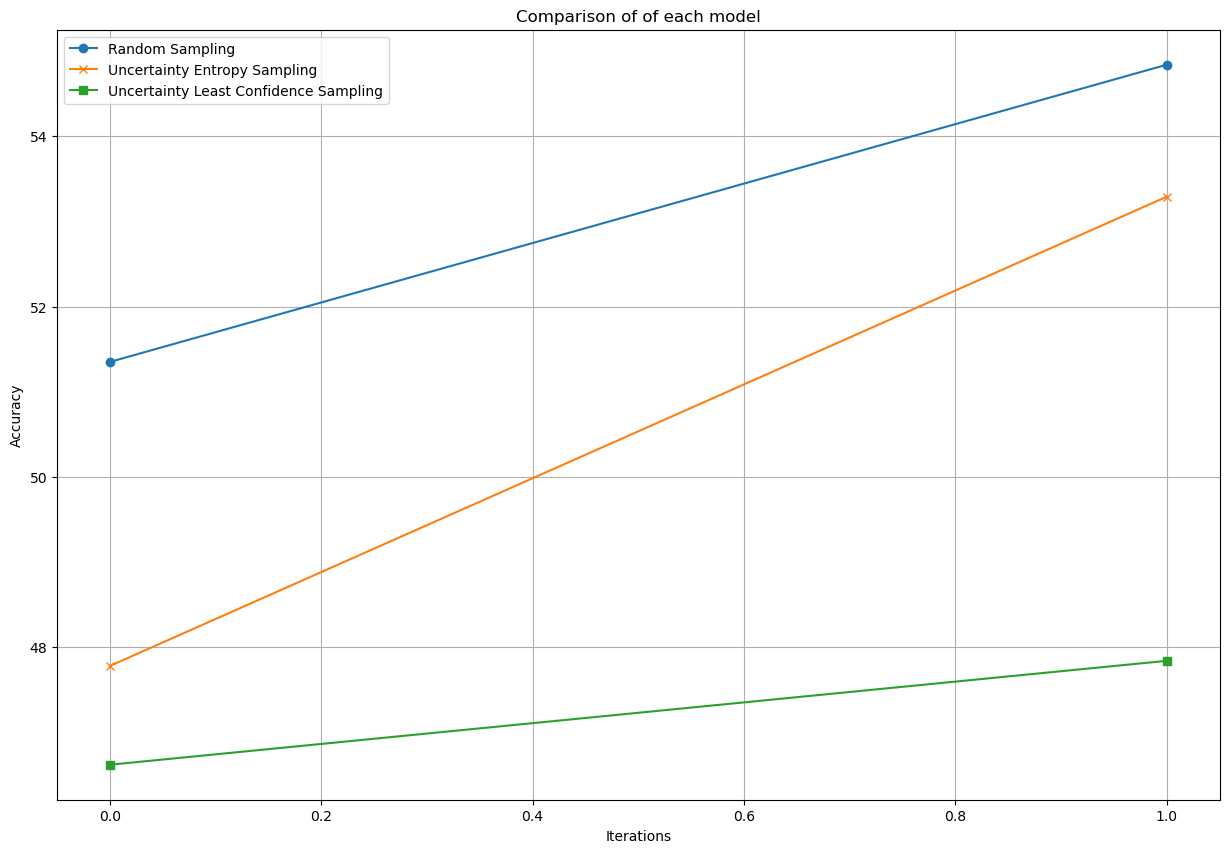

In [ ]:
plt.figure(figsize=(15, 10))  # Increase the size of the figure
plt.plot(random_accuracies, 'o-', label='Random Sampling')  # Add circle markers
plt.plot(entropy_accuracies, 'x-', label='Uncertainty Entropy Sampling')  # Add x markers
plt.plot(least_confidence_accuracies, 's-', label='Uncertainty Least Confidence Sampling')  # Add square markers
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Comparison of of each model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# final accuracies for each model

print(f'Random Sampling Final Accuracy: {random_accuracies[-1]:.2f}%')
print(f'Entropy Sampling Final Accuracy: {entropy_accuracies[-1]:.2f}%')
print(f'Least Confidence Sampling Final Accuracy: {least_confidence_accuracies[-1]:.2f}%')

Random Sampling Final Accuracy: 54.84%
Entropy Sampling Final Accuracy: 53.29%
Least Confidence Sampling Final Accuracy: 47.84%
